# Trabalho A1 - Análise de Séries Temporais

## Instruções do Trabalho

Utilize o conjunto de dados `data.csv` disponibilizado no e-class. O arquivo contém as variáveis `week` e `volume`. Seu objetivo é modelar a variável `volume` utilizando os conceitos aprendidos em sala de aula.

**Linguagem de Programação:** Você pode utilizar Python ou R como linguagem de programação.

## Requisitos do Trabalho

Seu trabalho deve conter:

* **Discussão sobre métricas e métodos de avaliação**

* **Discussão sobre a necessidade de transformação de variáveis**

* **Discussão sobre a necessidade de decomposição entre tendência e sazonalidade**

* **Análises de resíduos e ajuste dos modelos**

* **Modelos baselines**

* **Modelos de regressão linear múltipla** utilizando co-variáveis criadas baseadas nas variáveis `week` e `volume`

## Entrega

Sua entrega deve conter:
- Link para um repositório no GitHub contendo o código
- Relatório de no máximo 5 páginas contendo um resumo executivo das suas análises


## Contexto

Ao longo do curso será disponibilizado mais variáveis para melhorar os resultados obtidos na A1.

## Bibliotecas

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.base import ForecastingHorizon
from sktime.performance_metrics.forecasting import (
    mean_absolute_error, mean_squared_error,
    mean_absolute_percentage_error, MeanAbsoluteScaledError,
)
from scipy.stats import boxcox
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL

## Dados

In [66]:
prison = pd.read_csv("data.csv")

In [67]:
prison.head(6)

,week,volume
0,2022-10-31,0.33
1,2022-11-07,0.47
2,2022-11-14,0.32
3,2022-11-21,1.69
4,2022-11-28,1.23
5,2022-12-05,0.77


In [68]:
prison.tail(6)

,week,volume
144,2025-08-04,13.43
145,2025-08-11,13.60
146,2025-08-18,15.20
147,2025-08-25,16.24
148,2025-09-01,13.43
149,2025-09-08,16.59


In [69]:
# Converte a coluna "week" para datetime
prison["week"] = pd.to_datetime(prison["week"])

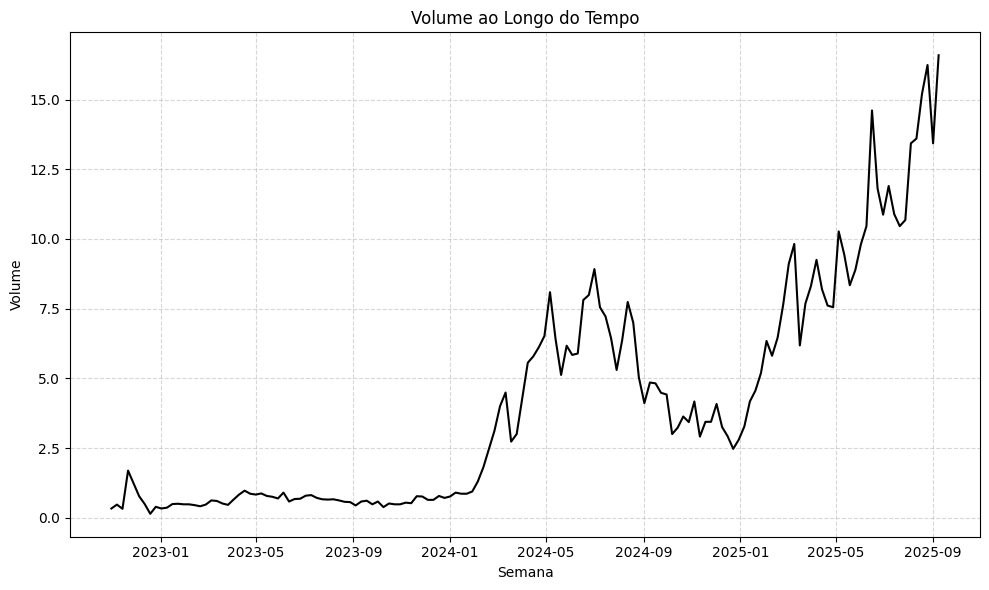

In [70]:
# Criar o gráfico
plt.figure(figsize=(10, 6))
plt.plot(prison["week"], prison["volume"], linestyle='-', marker='', color='black')

# Labels e título
plt.xlabel("Semana")
plt.ylabel("Volume")
plt.title("Volume ao Longo do Tempo")

# Estilo minimalista
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

## Baselines

In [71]:
# série semanal com frequência explícita
y = prison.sort_values("week").set_index("week")["volume"]
y = y.asfreq(pd.infer_freq(y.index) or "W")

h = 52  # horizonte
y_tr, y_te = y.iloc[:-h], y.iloc[-h:]
fh = ForecastingHorizon(np.arange(1, h + 1), is_relative=True)

In [72]:
def fit_pred(strategy, sp=1):
    f = NaiveForecaster(strategy=strategy, sp=sp)
    f.fit(y_tr)
    return f.predict(fh)

preds = {
    "mean":  fit_pred("mean", sp=1),
    "naive": fit_pred("last", sp=1),
    "snaive": fit_pred("last", sp=52),   # sazonal 
    "drift": fit_pred("drift", sp=1),
}

mase_metric = MeanAbsoluteScaledError(sp=52)  

rows = []
for name, yhat in preds.items():
    rows.append({
        "model": name,
        "MAE":  mean_absolute_error(y_te, yhat),
        "RMSE": mean_squared_error(y_te, yhat, square_root=True),
        "MAPE_%": mean_absolute_percentage_error(y_te, yhat) * 100,
        "MASE": mase_metric(y_te, yhat, y_train=y_tr),
    })

metrics = pd.DataFrame(rows).sort_values("RMSE").round(3)
metrics

,model,MAE,RMSE,MAPE_%,MASE
3,drift,2.894,3.671,39.182,0.836
2,snaive,4.083,4.621,59.579,1.180
1,naive,3.763,4.857,44.402,1.088
0,mean,5.485,6.748,61.472,1.585


## Transformação de Variáveis

In [73]:
prison = prison.set_index('week')
y = prison['volume']

y_bc, lmbda = boxcox(y)

print(f"O valor de lambda (λ) é: {lmbda:.4f}")

O valor de lambda (λ) é: 0.0496


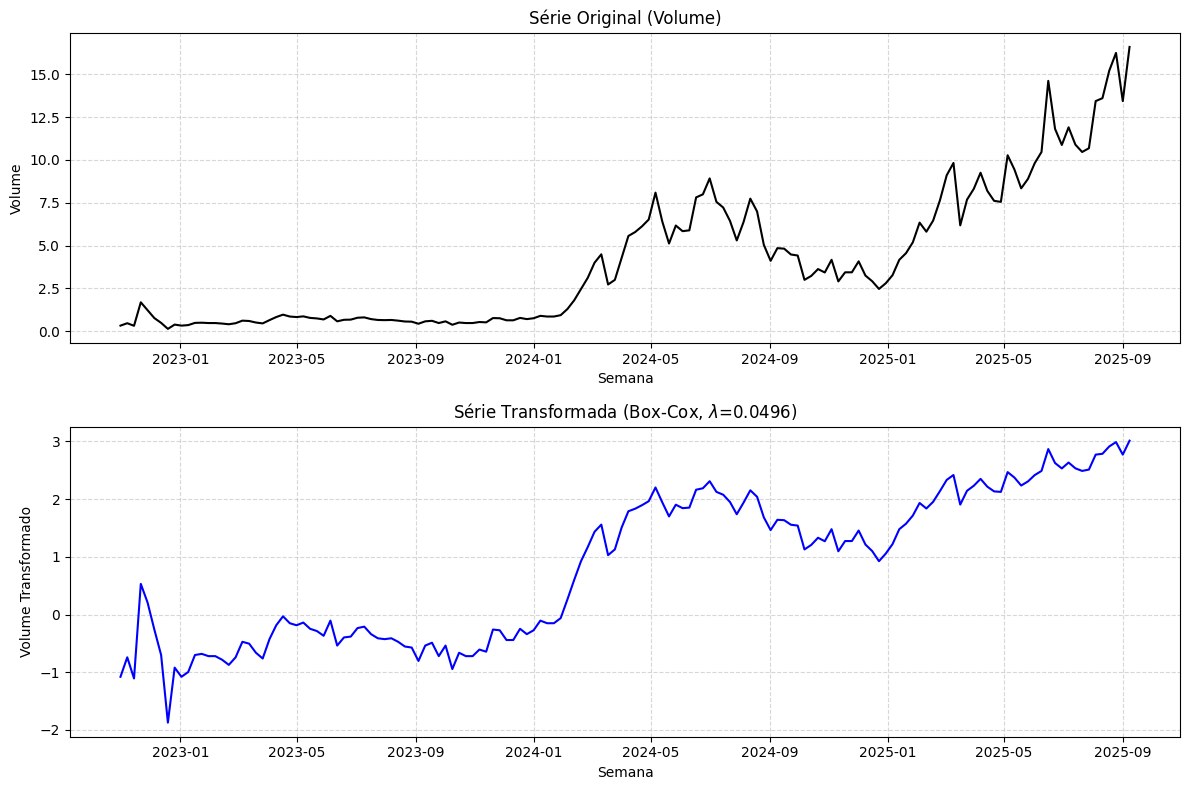

In [74]:
# Armazena a série transformada no DataFrame para futuras modelagens
prison['volume_bc'] = y_bc

# Criar o gráfico
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Série Original
axes[0].plot(prison['volume'], linestyle='-', color='black')
axes[0].set_title('Série Original (Volume)')
axes[0].set_ylabel('Volume')
axes[0].set_xlabel('Semana')
axes[0].grid(True, linestyle='--', alpha=0.5)

# Série Transformada
axes[1].plot(prison['volume_bc'], linestyle='-', color='blue')
axes[1].set_title(f'Série Transformada (Box-Cox, $\\lambda$={lmbda:.4f})')
axes[1].set_ylabel('Volume Transformado')
axes[1].set_xlabel('Semana')
axes[1].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

## Decomposição STL


In [77]:
series_orig = prison["volume"].asfreq(pd.infer_freq(prison.index) or "W")
stl_orig = STL(series_orig, period=52, robust=True).fit()

In [78]:
series_bc = prison["volume_bc"].asfreq(pd.infer_freq(prison.index) or "W")
stl_bc = STL(series_bc, period=52, robust=True).fit()

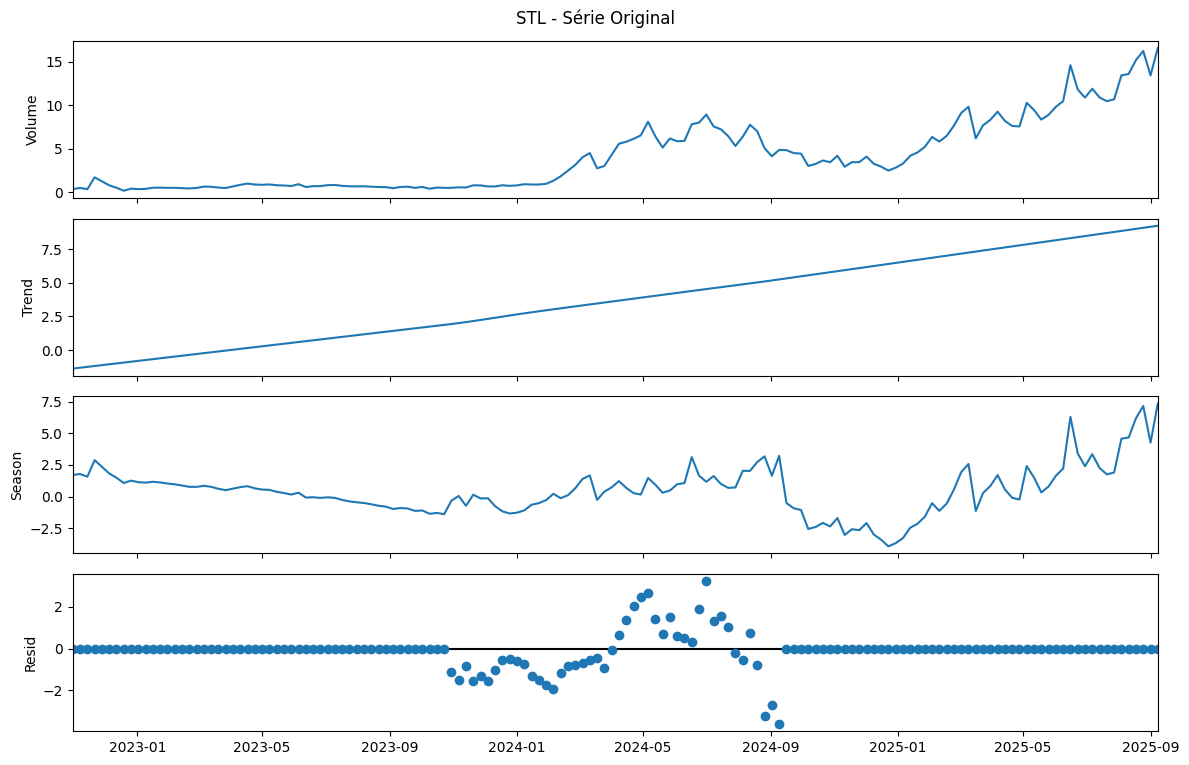

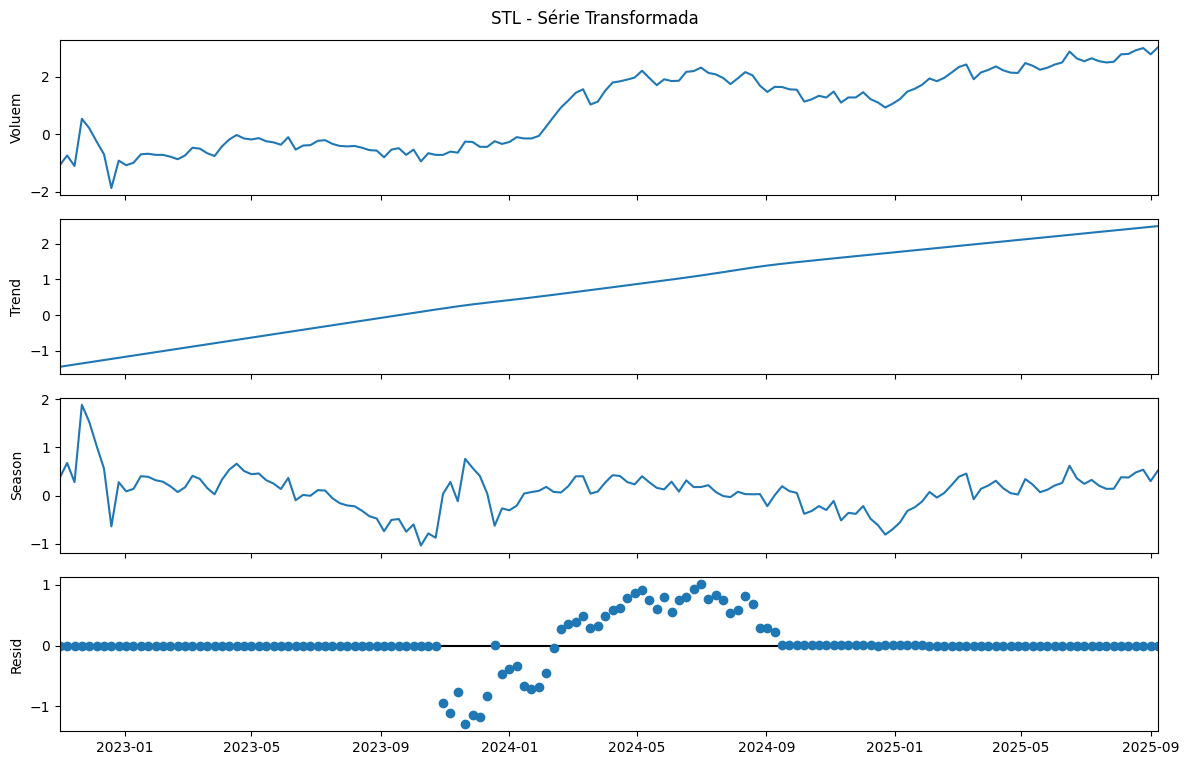

In [86]:
fig = stl_orig.plot()
fig.set_size_inches(12, 8)
plt.suptitle("STL - Série Original", y=0.95)
plt.tight_layout()
axes = fig.get_axes()
axes[0].set_title("")
axes[0].set_ylabel("Volume")
plt.show()

fig = stl_bc.plot()
fig.set_size_inches(12, 8)
plt.suptitle("STL - Série Transformada", y=0.95)
plt.tight_layout()
axes = fig.get_axes()
axes[0].set_title("")
axes[0].set_ylabel("Voluem")
plt.show()


In [76]:
# Séries ajustadas sazonalmente (removendo a componente sazonal)
prison["volume_sa"] = (series_orig - stl_orig.seasonal).reindex(prison.index)
prison["volume_bc_sa"] = (series_bc - stl_bc.seasonal).reindex(prison.index)
prison

,volume,volume_bc,volume_sa,volume_bc_sa
week,,,,
2022-10-31,0.33,-1.078718,-1.372300,-1.449177
2022-11-07,0.47,-0.741054,-1.308687,-1.417611
2022-11-14,0.32,-1.107820,-1.245073,-1.386045
2022-11-21,1.69,0.531620,-1.181460,-1.354480
2022-11-28,1.23,0.208081,-1.117846,-1.322916
...,...,...,...,...
2025-08-11,13.60,2.786634,8.940453,2.412550
2025-08-18,15.20,2.913590,9.017225,2.432937
2025-08-25,16.24,2.989465,9.093997,2.453323


### Comparação de Séries

In [50]:
def train_baselines_and_metrics(y_series, h=52, sp=52):
    """
    Treina baselines e calcula métricas para qualquer série temporal.

    """
    # Divide em treino e teste
    y_tr, y_te = y_series.iloc[:-h], y_series.iloc[-h:]
    fh = ForecastingHorizon(np.arange(1, h + 1), is_relative=True)
    
    def fit_pred(strategy, sp=1):
        f = NaiveForecaster(strategy=strategy, sp=sp)
        f.fit(y_tr)
        return f.predict(fh)
    
    # Treina todos os baselines
    preds = {
        "mean":  fit_pred("mean", sp=1),
        "naive": fit_pred("last", sp=1),
        "snaive": fit_pred("last", sp=sp),   # sazonal
        "drift": fit_pred("drift", sp=1),
    }
    
    # Calcula métricas
    mase_metric = MeanAbsoluteScaledError(sp=sp)
    
    rows = []
    for name, yhat in preds.items():
        rows.append({
            "model": name,
            "MAE":  mean_absolute_error(y_te, yhat),
            "RMSE": mean_squared_error(y_te, yhat, square_root=True),
            "MAPE_%": mean_absolute_percentage_error(y_te, yhat) * 100,
            "MASE": mase_metric(y_te, yhat, y_train=y_tr),
        })
    
    return pd.DataFrame(rows).sort_values("RMSE").round(3), preds, y_tr, y_te

In [51]:
# Aplica a função anterior na série transformada
y_bc = prison["volume_bc"]
y_bc = y_bc.asfreq(pd.infer_freq(y_bc.index) or "W")
metrics_bc, preds_bc, y_tr_bc, y_te_bc = train_baselines_and_metrics(y_bc, h=52, sp=52)

In [52]:
# Comparação lado a lado
print("=== MÉTRICAS - SÉRIE ORIGINAL ===")
print(metrics)
print("\n=== MÉTRICAS - SÉRIE BOX-COX ===")
print(metrics_bc)

=== MÉTRICAS - SÉRIE ORIGINAL ===
    model    MAE   RMSE  MAPE_%   MASE
3   drift  2.894  3.671  39.182  0.836
2  snaive  4.083  4.621  59.579  1.180
1   naive  3.763  4.857  44.402  1.088
0    mean  5.485  6.748  61.472  1.585

=== MÉTRICAS - SÉRIE BOX-COX ===
    model    MAE   RMSE  MAPE_%   MASE
3   drift  0.391  0.472  26.115  0.236
1   naive  0.603  0.700  29.641  0.364
2  snaive  1.130  1.283  70.674  0.681
0    mean  1.784  1.883  87.965  1.076


## Resíduos

In [53]:
residuos = {name: y_te - yhat for name, yhat in preds.items()}
residuos_bc = {name: y_te_bc - yhat for name, yhat in preds_bc.items()}

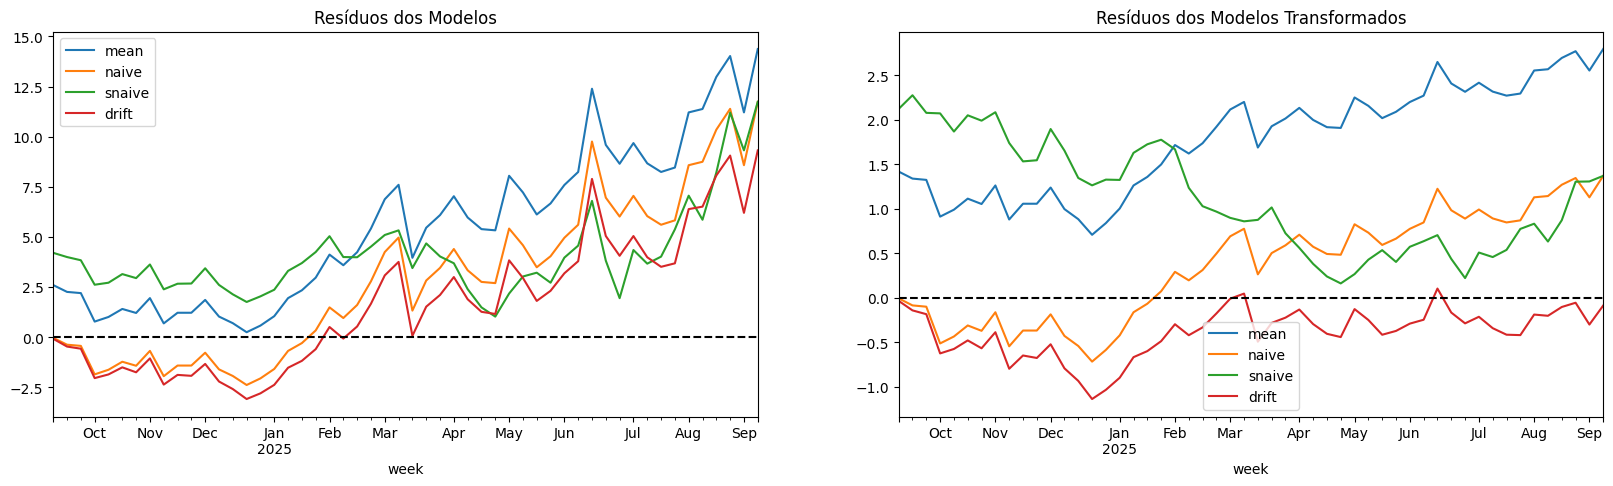

In [54]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

for name, res in residuos.items():
    res.plot(ax=ax[0], label=name)

for name, res in residuos_bc.items():
    res.plot(ax=ax[1], label=name)

ax[0].axhline(0, color="black", linestyle="--")
ax[0].set_title("Resíduos dos Modelos")
ax[0].legend()

ax[1].axhline(0, color="black", linestyle="--")
ax[1].set_title("Resíduos dos Modelos Transformados")
ax[1].legend()

plt.show()

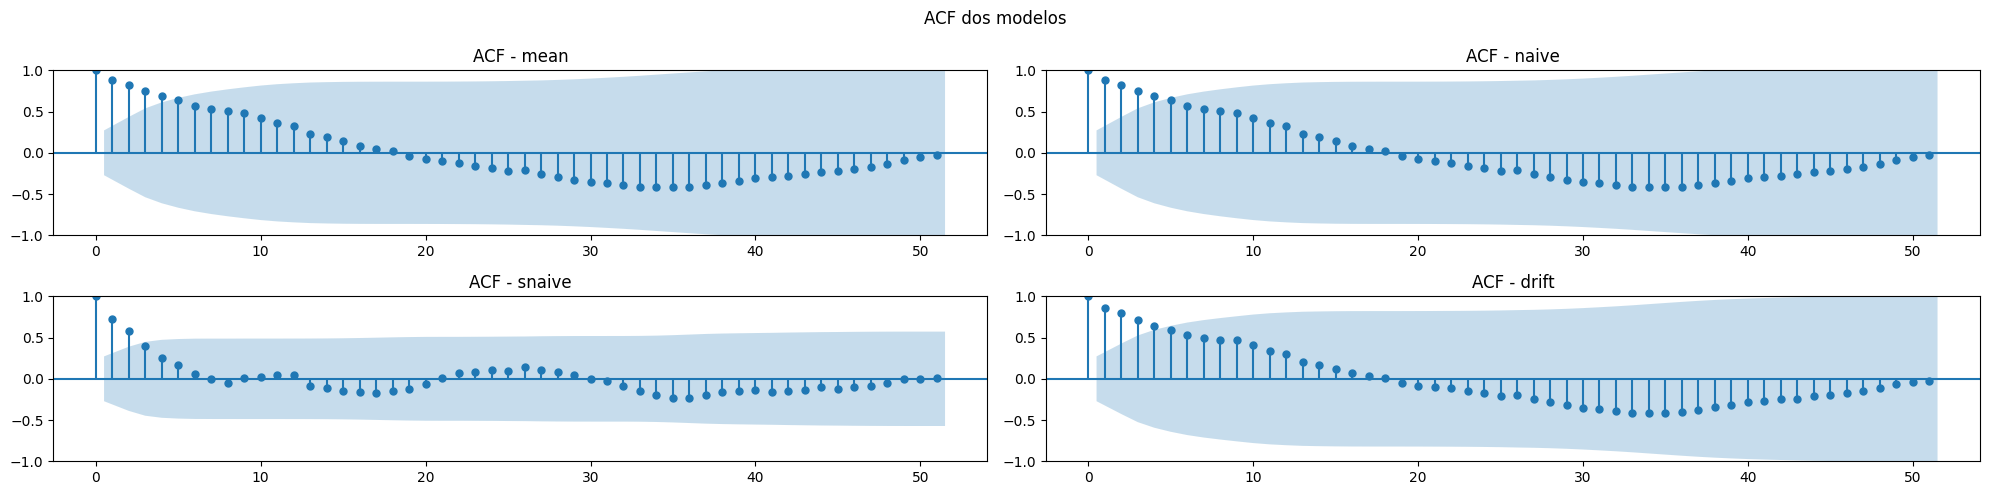

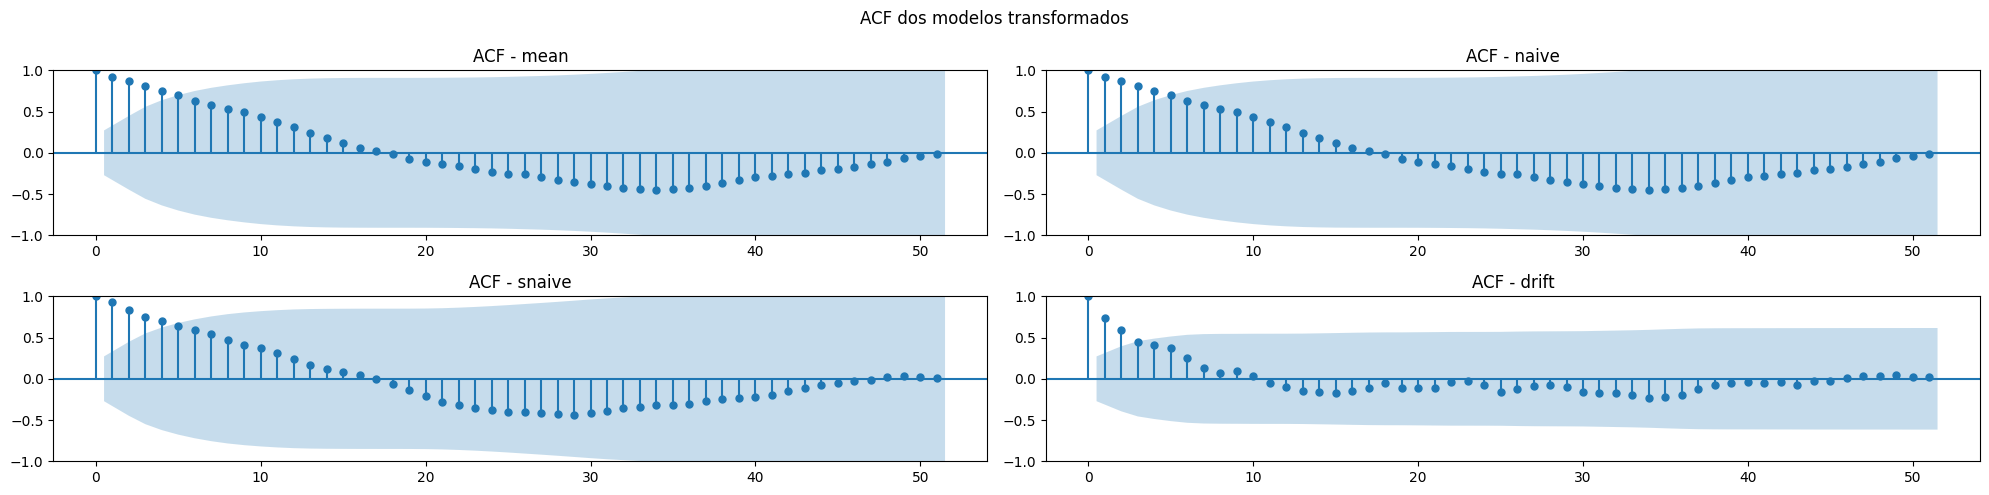

In [55]:
fig, axes = plt.subplots(2, 2, figsize=(20, 5))

for ax, (name, res) in zip(axes.flatten(), residuos.items()):
    plot_acf(res, lags=h-1, ax=ax)
    ax.set_title(f"ACF - {name}")

plt.suptitle("ACF dos modelos")

plt.tight_layout()

plt.show()

fig, axes = plt.subplots(2, 2, figsize=(20, 5))

for ax, (name, res) in zip(axes.flatten(), residuos_bc.items()):
    plot_acf(res, lags=h-1, ax=ax)
    ax.set_title(f"ACF - {name}")

plt.suptitle("ACF dos modelos transformados")

plt.tight_layout()

plt.show()

In [56]:
print("Ljung-Box p-value dos modelos")
for name, res in residuos.items():
    lb_test = acorr_ljungbox(res, lags=[10], return_df=True)
    print(f"{name}: {lb_test["lb_pvalue"].values[0]}")

print("\n")
print("Ljung-Box p-value dos modelos transformados")
for name, res in residuos_bc.items():
    lb_test = acorr_ljungbox(res, lags=[10], return_df=True)
    print(f"{name}: {lb_test["lb_pvalue"].values[0]}")

Ljung-Box p-value dos modelos
mean: 2.697368535557789e-47
naive: 2.6973685355576355e-47
snaive: 1.32490690156316e-09
drift: 3.360549175219557e-42


Ljung-Box p-value dos modelos transformados
mean: 3.2507163516596577e-54
naive: 3.2507163516597504e-54
snaive: 4.2938448288408987e-47
drift: 2.5156410938116654e-14


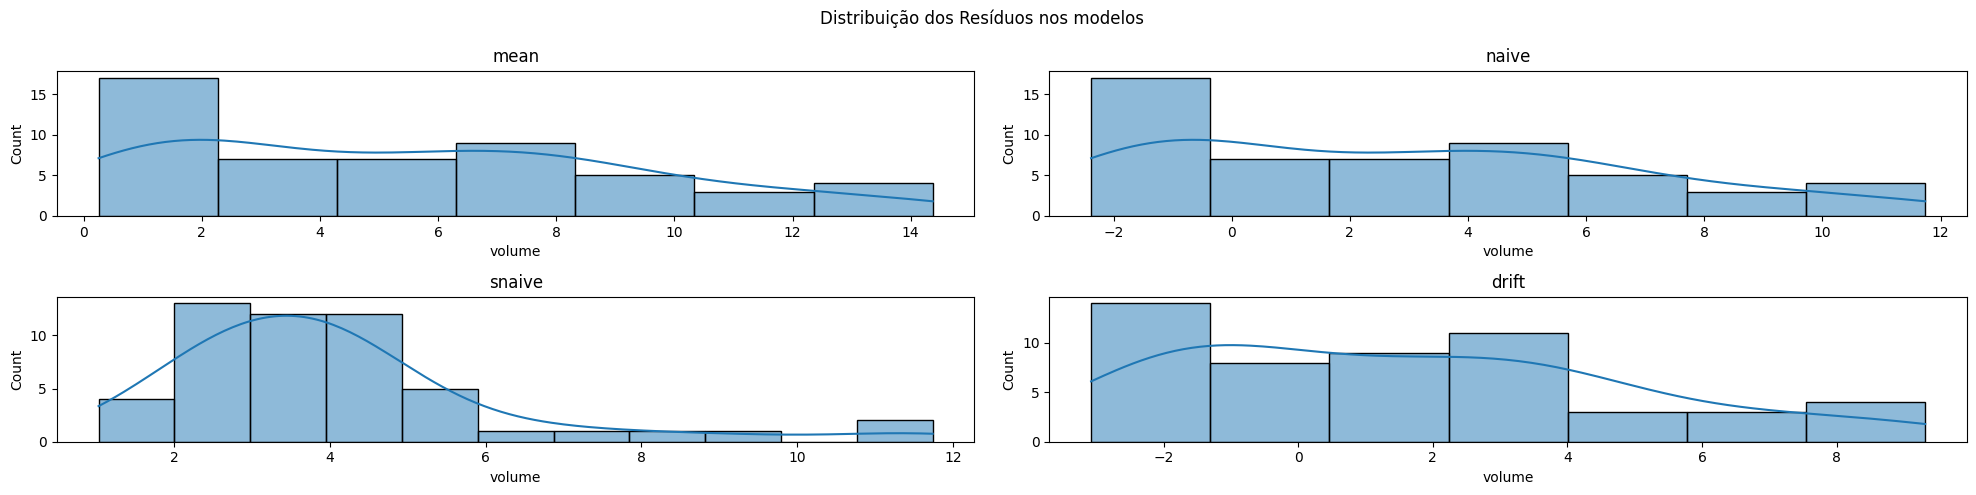

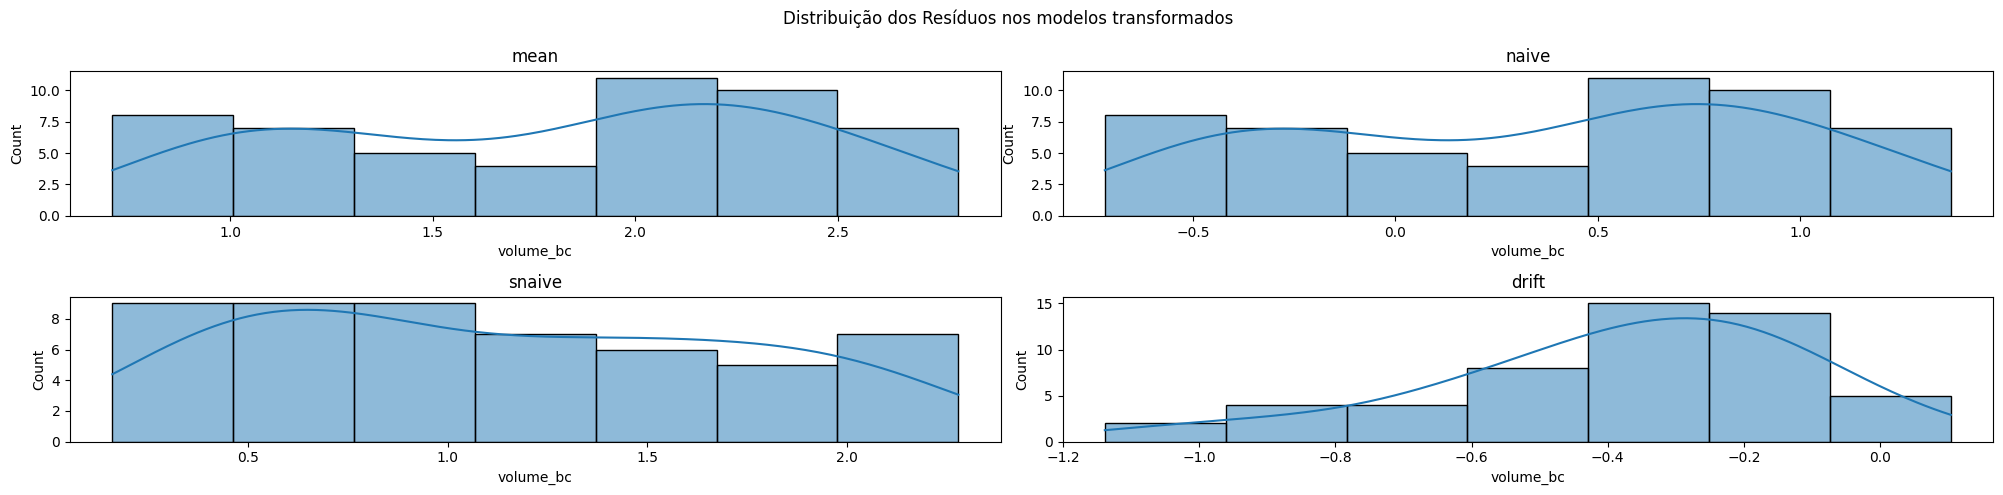

In [57]:
fig, axes = plt.subplots(2, 2, figsize=(20, 5))

for ax, (name, res) in zip(axes.flatten(), residuos.items()):
    sns.histplot(res, kde=True, ax=ax)
    ax.set_title(name)

plt.suptitle("Distribuição dos Resíduos nos modelos")
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(2, 2, figsize=(20, 5))

for ax, (name, res) in zip(axes.flatten(), residuos_bc.items()):
    sns.histplot(res, kde=True, ax=ax)
    ax.set_title(name)
    
plt.suptitle("Distribuição dos Resíduos nos modelos transformados")
plt.tight_layout()
plt.show()

# Modelo de Regressão

In [58]:
prison = prison.reset_index()

In [59]:

prison["week_num"] = prison["week"].map(pd.Timestamp.toordinal)

X = prison[["week_num"]]
y = prison["volume"]

# h = 52

X_train, X_test = X.iloc[:-h], X.iloc[-h:]
y_train, y_test = y.iloc[:-h], y.iloc[-h:]

In [60]:
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [61]:
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print("MAE:", mae)
print("RMSE:", rmse)

MAE: 2.467259088481469
RMSE: 8.97575113436329


In [62]:
coef_df = pd.DataFrame({
    "feature": X.columns,
    "coef": model.coef_
}).sort_values("coef", key=abs, ascending=False)

print(coef_df)

    feature      coef
0  week_num  0.010009


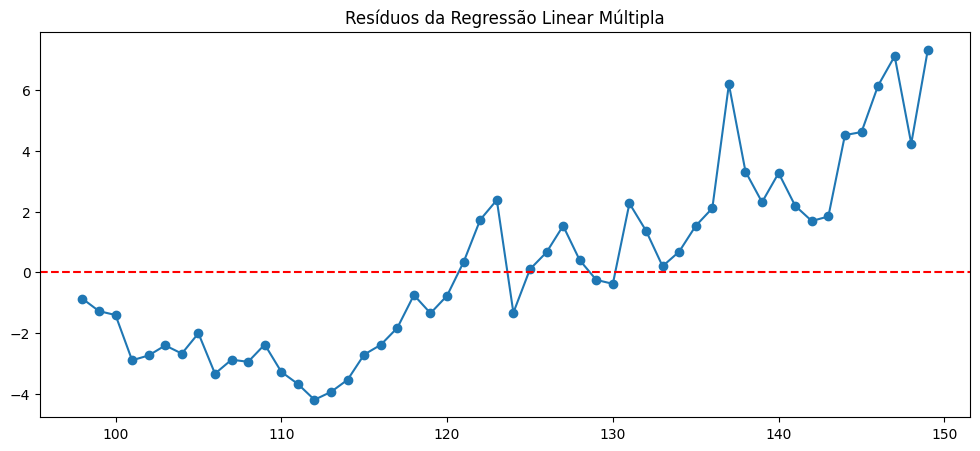

In [63]:
residuos = y_test - y_pred

plt.figure(figsize=(12,5))
plt.plot(residuos, marker="o")
plt.axhline(0, color="red", linestyle="--")
plt.title("Resíduos da Regressão Linear Múltipla")
plt.show()

In [64]:
# Adiciona intercepto
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

ols_model = sm.OLS(y_train, X_train_sm).fit()

y_pred = ols_model.predict(X_test_sm)

print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                 volume   R-squared:                       0.618
Model:                            OLS   Adj. R-squared:                  0.614
Method:                 Least Squares   F-statistic:                     155.6
Date:                Sun, 05 Oct 2025   Prob (F-statistic):           8.50e-22
Time:                        09:36:23   Log-Likelihood:                -182.45
No. Observations:                  98   AIC:                             368.9
Df Residuals:                      96   BIC:                             374.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -7392.7586    592.900    -12.469      0.0